In [1]:
%cd ..

/Users/crupley/gal/hoodie


In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cPickle as pickle

import networkx as nx

In [3]:
f = pickle.load(open('features.pkl', 'rb'))
df = f.fsmooth.copy()
edges = pickle.load(open('edges.pkl', 'rb'))

In [108]:
cuts = pd.read_csv('results/gall.csv', parse_dates='timestamp')
print cuts.shape
cuts.head()

(23555, 4)


,(source,target),num_edges,timestamp
0,(3535,2429),23555,1.447737e+09
1,(3724,1828),23554,1.447738e+09
2,(1828,4425),23553,1.447738e+09
3,(3521,6453),23552,1.447738e+09
4,(5562,2602),23551,1.447738e+09


In [109]:
cuts.columns = ['node1', 'node2', 'num_edges', 'timestamp']

In [110]:
cuts['node1'] = cuts['node1'].apply(lambda x: x.split('(')[-1]).astype('int')

In [111]:
cuts['node2'] = cuts['node2'].apply(lambda x: x.strip().split(')')[0]).astype('int')

In [112]:
cuts.timestamp = pd.to_datetime(cuts.timestamp, unit='s')

In [113]:
cuts.head()

,node1,node2,num_edges,timestamp
0,3535,2429,23555,2015-11-17 05:18:02.755126
1,3724,1828,23554,2015-11-17 05:18:35.590452
2,1828,4425,23553,2015-11-17 05:19:08.256799
3,3521,6453,23552,2015-11-17 05:19:40.537327
4,5562,2602,23551,2015-11-17 05:20:15.989270


In [154]:
g = nx.from_pandas_dataframe(cuts, 'node1', 'node2')
print g.number_of_edges()
print g.number_of_nodes()

23555
7325


In [129]:
print nx.number_connected_components(g)

5


In [130]:
len(max(nx.connected_components(g), key=len))

7295

In [131]:
def cutcon(row):
    g.remove_edge(row.node1, row.node2)
    return nx.number_connected_components(g)

In [132]:
cuts[cuts.node1 == 3535]

,node1,node2,num_edges,timestamp
0,3535,2429,23555,2015-11-17 05:18:02.755126


In [140]:
%time cuts['cutcon'] = cuts.apply(cutcon, axis = 1)

CPU times: user 8min 10s, sys: 4 s, total: 8min 14s
Wall time: 8min 15s


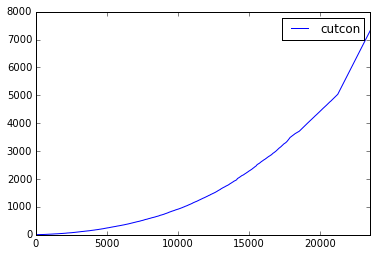

In [143]:
cuts.plot(y='cutcon')

In [144]:
def bigsize(row):
    g.remove_edge(row.node1, row.node2)
    return len(max(nx.connected_components(g), key=len))

In [151]:
%time cuts['max_cluster'] = cuts.apply(bigsize, axis=1)

CPU times: user 7min 38s, sys: 3.98 s, total: 7min 42s
Wall time: 7min 44s


In [152]:
cuts.head()

,node1,node2,num_edges,timestamp,cutcon,max_cluster
0,3535,2429,23555,2015-11-17 05:18:02.755126,5,7295
1,3724,1828,23554,2015-11-17 05:18:35.590452,5,7295
2,1828,4425,23553,2015-11-17 05:19:08.256799,5,7295
3,3521,6453,23552,2015-11-17 05:19:40.537327,5,7295
4,5562,2602,23551,2015-11-17 05:20:15.989270,5,7295


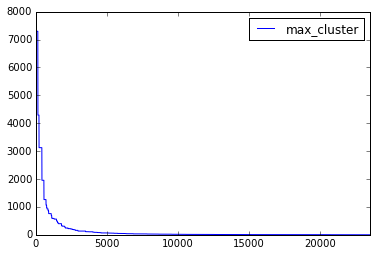

In [153]:
cuts.plot(y='max_cluster')

In [158]:
[len(i) for i in list(nx.connected_components(g))]

[7295, 22, 4, 2, 2]

In [165]:
g = nx.from_pandas_dataframe(cuts, 'node1', 'node2')
print g.number_of_edges()
print g.number_of_nodes()

23555
7325


In [166]:
# reduces graph to 6 clusters
cuts[cuts.cutcon <= 6].apply(cutcon, axis=1);

In [179]:
# cluster sizes
[len(i) for i in list(nx.connected_components(g))]

[4291, 3004, 22, 4, 2, 2]

In [209]:
def assign_clusters(df, graph):
    cc = list(nx.connected_components(graph))
    
    cnum = pd.Series(-1, index=df.index)
    for row in df.index:
        for i, cluster in enumerate(cc):
#             print row, i, len(cluster)
            if row in cluster: cnum.ix[row] = i
                
    return cnum

In [210]:
%time df['cnum'] = assign_clusters(df, g)

CPU times: user 689 ms, sys: 49.8 ms, total: 739 ms
Wall time: 708 ms


In [214]:
df.groupby('cnum').count()

,lat,lon,taxable_value,grocery,restaurant,retail,ncrimes,sgnf,avg_hh_size,population,walkscore
cnum,,,,,,,,,,,
-1,9,9,9,9,9,9,9,9,9,9,9
0,4291,4291,4291,4291,4291,4291,4291,4291,4291,4291,4291
1,3004,3004,3004,3004,3004,3004,3004,3004,3004,3004,3004
2,22,22,22,22,22,22,22,22,22,22,22
3,4,4,4,4,4,4,4,4,4,4,4
4,2,2,2,2,2,2,2,2,2,2,2
5,2,2,2,2,2,2,2,2,2,2,2


In [215]:
# feature mean by group
df.groupby('cnum').mean()

,lat,lon,taxable_value,grocery,restaurant,retail,ncrimes,sgnf,avg_hh_size,population,walkscore
cnum,,,,,,,,,,,
-1,37.772803,-122.476444,-1.844821,-0.780759,-0.376512,-0.829723,-0.316682,-2.315585,-1.585990,-0.883098,-3.569271
0,37.765990,-122.416978,0.113511,0.308534,0.236493,0.337745,0.279914,-0.189304,-0.363674,0.050168,0.186821
1,37.742204,-122.465004,-0.088809,-0.430184,-0.332017,-0.471465,-0.422765,0.295742,0.543913,-0.048133,-0.218225
2,37.810562,-122.365263,-8.085101,-0.844874,-0.497911,-0.880369,3.161652,-1.767449,-1.945063,-2.452607,-4.083061
3,37.711443,-122.494967,0.574274,-0.802308,-0.372675,-0.854991,-0.286227,-1.910613,-2.089998,-0.414820,-3.906850
4,37.818908,-122.370744,-7.886234,-0.999162,-0.430066,-0.830920,1.988845,-2.143000,-2.077212,-2.466023,-2.389727
5,37.774846,-122.383487,-6.171869,-0.412285,-0.360198,-0.532865,-0.331642,-2.227498,-1.905731,-1.091728,-1.872452


In [216]:
df.head()

,lat,lon,taxable_value,grocery,restaurant,retail,ncrimes,sgnf,avg_hh_size,population,walkscore,cnum
0,37.750067,-122.441075,0.288994,-0.640949,-0.561362,-0.582297,-0.509058,0.477959,-0.017894,-0.102338,-0.025533,0
1,37.750196,-122.438933,0.336486,-0.576766,-0.465886,-0.515304,-0.509038,1.060608,0.253293,0.043369,0.146457,0
2,37.756794,-122.436270,0.350392,-0.131126,-0.396314,-0.227381,-0.313369,0.276664,0.244508,0.413731,0.701471,0
3,37.753529,-122.437050,0.327277,-0.298948,-0.286766,-0.356888,-0.456736,0.945703,0.372523,0.260021,0.594762,0
4,37.755758,-122.433400,0.355234,0.018376,-0.470065,-0.123353,-0.345027,0.674973,0.360681,0.530529,0.622791,0


# MSE

In [218]:
from code.featurize import sim

In [241]:
def row_errorsq(row, cluster_means):
    rowf = row.drop(['cnum'])
    return (sim(rowf, cluster_means.ix[int(row.cnum)]))**2

def wcss(df):
    dfcp = df.copy()
    features = df.drop(['lat', 'lon'], axis = 1)
    cluster_means = features.groupby('cnum').mean()
    dfcp['errors'] = features.apply(lambda x: row_errorsq(x, cluster_means), axis = 1)

    return dfcp.groupby('cnum').sum().iloc[:,0]

In [228]:
features = df.drop(['lat', 'lon'], axis = 1)
cluster_means = features.groupby('cnum').mean()
features = features.drop(['cnum'], axis = 1)

In [229]:
row_error(features.ix[0], cluster_means)

1.9159841159785016

In [232]:
df.cnum.unique()

array([ 0,  1,  2, -1,  3,  4,  5])

In [234]:
cluster_means.index

Int64Index([-1, 0, 1, 2, 3, 4, 5], dtype='int64', name=u'cnum')

In [242]:
row_errorsq(df.ix[6].drop(['lat', 'lon']), cluster_means)

0.49265919494279858

In [243]:
wcss = wcss(df)
wcss

cnum
-1       339.955228
 0    162053.863407
 1    113377.580485
 2       831.832356
 3       150.845770
 4        75.637816
 5        75.549692
Name: lat, dtype: float64

In [247]:
wcss.ix[wcss.index >= 0].sum()

276565.30952650058

In [11]:
import code.assessment as a

In [250]:
a.wcss(df)

cnum
-1       339.955228
 0    162053.863407
 1    113377.580485
 2       831.832356
 3       150.845770
 4        75.637816
 5        75.549692
Name: lat, dtype: float64

In [258]:
%%time
# rebuild full graph
g = nx.from_pandas_dataframe(cuts, 'node1', 'node2')
print g.number_of_edges()
print g.number_of_nodes()

# reduces graph to 7 clusters
cuts[cuts.cutcon <= 7].apply(cutcon, axis=1)

# assign cluster numbers
df['cnum'] = a.assign_clusters(df, g)
    
wcss = a.wcss(df)
print 'WCSSE:', wcss.ix[wcss.index >= 0].sum()
wcss

23555
7325
WCSSE: 276565.309527
CPU times: user 13.1 s, sys: 146 ms, total: 13.2 s
Wall time: 13.3 s


In [257]:
# cluster sizes
[len(i) for i in list(nx.connected_components(g))]

[3123, 3004, 1168, 22, 4, 2, 2]

# WCSS vs k

In [331]:
%%time
ks = range(5, 50)
wcsses = []

for k in ks:
    # rebuild full graph
    g = nx.from_pandas_dataframe(cuts, 'node1', 'node2')

    # reduces graph to i clusters
    cuts[cuts.cutcon <= k].apply(lambda x: a.cutrow(x, g), axis=1)

    # assign cluster numbers
    df['cnum'] = a.assign_clusters(df, g)

    wcss = a.wcss(df)
    wcsses.append(wcss.ix[wcss.index >= 0].sum())
    print 'k:', k, 'WCSSE:', wcss.ix[wcss.index >= 0].sum()

k: 5 WCSSE: 62943.3522147
k: 6 WCSSE: 57127.9701474
k: 7 WCSSE: 50773.7637482
k: 8 WCSSE: 50593.8892796
k: 9 WCSSE: 50191.3728975
k: 10 WCSSE: 45946.1376034
k: 11 WCSSE: 45616.929768
k: 12 WCSSE: 43299.7427363
k: 13 WCSSE: 43139.7241871
k: 14 WCSSE: 43042.1116143
k: 15 WCSSE: 41206.720455
k: 16 WCSSE: 39989.7560288
k: 17 WCSSE: 39449.798029
k: 18 WCSSE: 39289.3415999
k: 19 WCSSE: 36759.784894
k: 20 WCSSE: 36616.6256164
k: 21 WCSSE: 36414.8138128
k: 22 WCSSE: 36270.5184127
k: 23 WCSSE: 35068.1851332
k: 24 WCSSE: 34973.9956628
k: 25 WCSSE: 34911.4738882
k: 26 WCSSE: 34267.9428485
k: 27 WCSSE: 33953.3211907
k: 28 WCSSE: 33409.4360867
k: 29 WCSSE: 33163.2896936
k: 30 WCSSE: 32882.5144344
k: 31 WCSSE: 31630.3460616
k: 32 WCSSE: 31625.4219502
k: 33 WCSSE: 31571.5800937
k: 34 WCSSE: 31518.7322294
k: 35 WCSSE: 31408.0424429
k: 36 WCSSE: 31314.265295
k: 37 WCSSE: 31247.4611318
k: 38 WCSSE: 31214.3760049
k: 39 WCSSE: 31113.0112337
k: 40 WCSSE: 30658.6385575
k: 41 WCSSE: 30573.2075365
k: 42 WCSSE

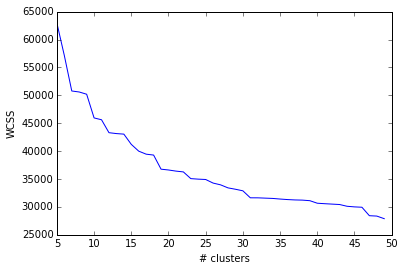

In [332]:
plt.plot(ks, wcsses)
plt.xlabel('# clusters')
plt.ylabel('WCSS');

In [378]:
# choose 20 clusters:
k = 20
g = nx.from_pandas_dataframe(cuts, 'node1', 'node2')

# reduces graph to i clusters
cuts[cuts.cutcon <= k].apply(lambda x: a.cutrow(x, g), axis=1)

# assign cluster numbers
df['cnum'] = a.assign_clusters(df, g)

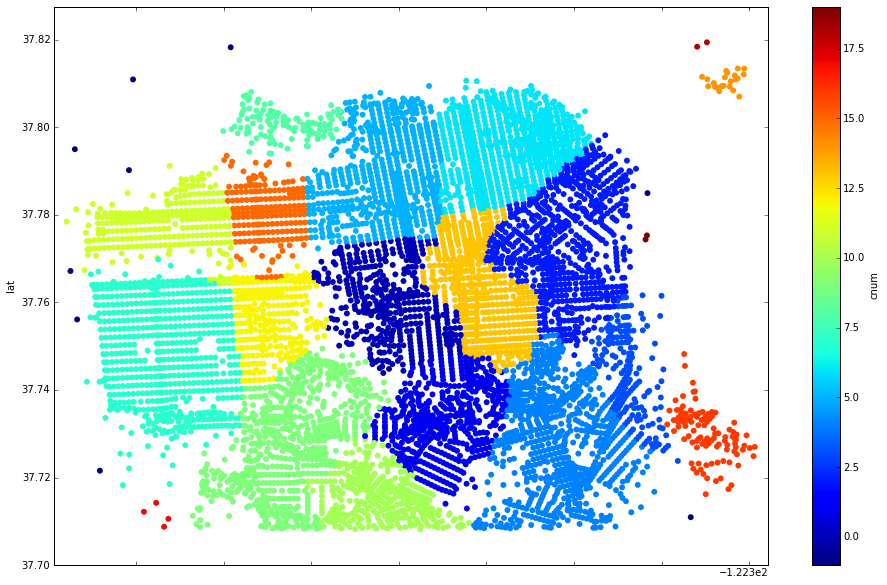

In [379]:
df.plot(kind='scatter', x = 'lon', y = 'lat', c = 'cnum',
        linewidths = 0, cmap = 'jet', figsize = (16, 10), s=35)
plt.axis('equal')
plt.margins(0);

# make shapefiles

In [348]:
import code.shapes as s
import shapely.geometry as geometry

In [380]:
dftoshapes = df[['lat', 'lon', 'cnum']][df.cnum >= 0]

In [381]:
polys = s.make_polys(dftoshapes)

In [382]:
polys

In [383]:
s.make_kml(polys, 'results/gall.kml')

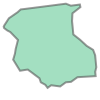

In [377]:
polys[0]

# barplots

In [426]:
dfbp = df.drop(['lat', 'lon'], axis = 1).groupby('cnum').mean()
dfbp = dfbp[dfbp.index >= 0]
dfbp

,taxable_value,grocery,restaurant,retail,ncrimes,sgnf,avg_hh_size,population,walkscore
cnum,,,,,,,,,
0,0.286761,-0.127785,-0.212409,-0.205252,-0.260572,0.335478,0.026377,0.478836,0.108134
1,-0.090070,-0.358383,-0.313665,-0.389250,-0.325123,0.371480,0.669585,-0.109376,-0.081799
2,0.301483,0.387074,0.575120,0.885188,0.998587,-0.837511,-1.146503,-0.349153,0.564860
3,-0.531665,-0.323295,-0.357317,-0.341119,-0.044800,-1.088046,-0.924610,-1.470348,-0.445924
4,-0.612270,-0.120966,-0.396757,-0.416812,-0.270107,-0.236071,0.406490,-0.649949,-0.291131
5,0.437399,-0.040578,0.014289,0.022271,-0.153114,0.482312,-0.207208,0.364528,0.560103
6,0.729198,1.630995,1.321145,1.719162,1.012146,0.258522,-0.543982,1.345536,0.881784
7,-0.183744,-0.491261,-0.425724,-0.571968,-0.515708,0.327667,0.563880,0.161005,-0.431138
8,0.404675,-0.641854,-0.576142,-0.806275,-0.575340,-1.770041,-1.600129,-1.810515,-2.829530


In [428]:
# scale all features 0-1
# must run twice?
for col in dfbp.columns:
    dfbp[col] = (dfbp[col] - dfbp[col].min()) / dfbp[col].max()
dfbp

,taxable_value,grocery,restaurant,retail,ncrimes,sgnf,avg_hh_size,population,walkscore
cnum,,,,,,,,,
0,0.949805,0.331302,0.191712,0.259708,0.084230,0.922883,0.613372,0.772613,0.844174
1,0.907052,0.243627,0.138343,0.188926,0.066957,0.935847,0.799787,0.618289,0.805919
2,0.951475,0.527054,0.606794,0.679183,0.421175,0.500510,0.273445,0.555382,0.936167
3,0.856953,0.256968,0.115336,0.207442,0.141970,0.410297,0.337755,0.261225,0.732578
4,0.847808,0.333895,0.094548,0.178323,0.081679,0.717079,0.723537,0.476465,0.763756
5,0.966895,0.364459,0.311197,0.347232,0.112986,0.975756,0.545674,0.742623,0.935208
6,1.000000,1.000000,1.000000,1.000000,0.424803,0.895173,0.448069,1.000000,1.000000
7,0.896425,0.193107,0.079280,0.118637,0.015957,0.920071,0.769152,0.689227,0.735556
8,0.963182,0.135850,0.000000,0.028503,0.000000,0.164722,0.141975,0.171979,0.252481


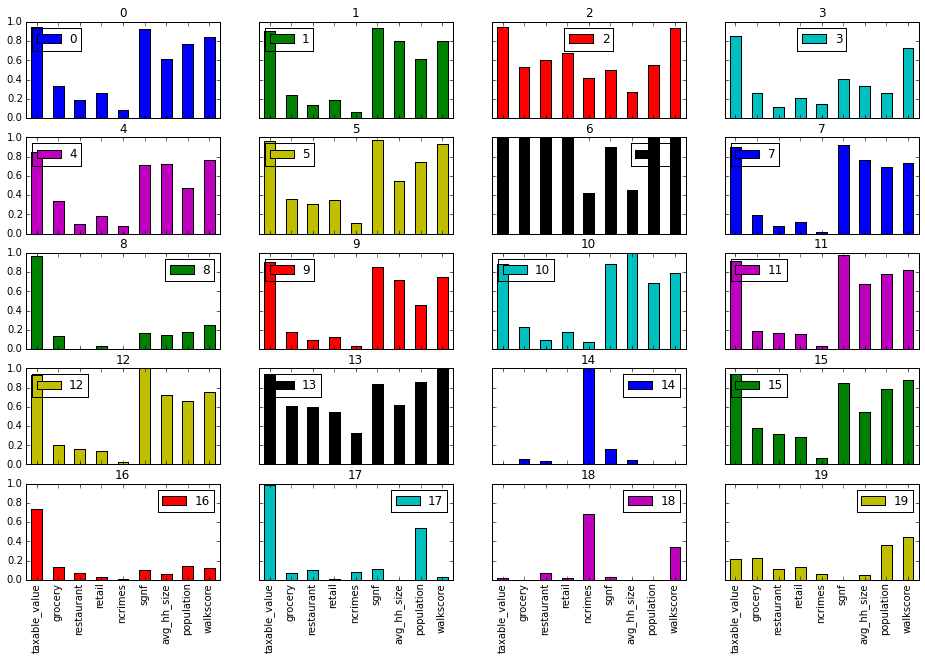

In [434]:
dfbp.T.plot(kind='bar', subplots=True, layout=(5,4), figsize = (16, 10), sharey=True);

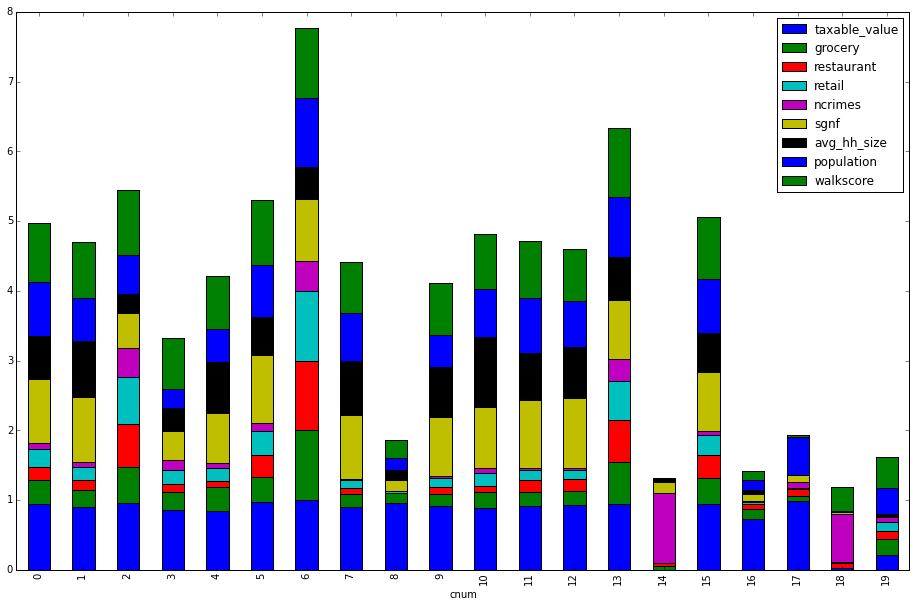

In [438]:
dfbp.plot(kind='bar', stacked=True, figsize = (16, 10));

# AWS nx cuts
## population, household size, sgnf

In [72]:
from matplotlib import colors
import matplotlib

In [4]:
cuts = pd.read_csv('results/g070605.csv')
print cuts.shape
cuts.head()

(1479, 6)


,node1,node2,size,edges,biggroup,timestamp
0,4869,6141,6,17038,7295,1.447538e+09
1,165,3618,6,17037,7295,1.447538e+09
2,953,3551,6,17036,7295,1.447539e+09
3,2602,5562,6,17035,7295,1.447539e+09
4,7,539,6,17034,7295,1.447540e+09


In [5]:
cuts.tail()

,node1,node2,size,edges,biggroup,timestamp
1474,3738,4833,33,15564,391,1.447809e+09
1475,3106,3218,33,15563,391,1.447809e+09
1476,4091,6466,33,15562,391,1.447809e+09
1477,2812,4094,33,15561,391,1.447809e+09
1478,3636,4070,33,15560,391,1.447809e+09


In [6]:
g = nx.from_pandas_dataframe(edges, 'node1', 'node2')
print g.number_of_edges()
print g.number_of_nodes()

23555
7325


In [7]:
df.head()

,lat,lon,taxable_value,grocery,restaurant,retail,ncrimes,sgnf,avg_hh_size,population,walkscore
0,37.750067,-122.441075,0.288994,-0.640949,-0.561362,-0.582297,-0.509058,0.477959,-0.017894,-0.102338,-0.025533
1,37.750196,-122.438933,0.336486,-0.576766,-0.465886,-0.515304,-0.509038,1.060608,0.253293,0.043369,0.146457
2,37.756794,-122.436270,0.350392,-0.131126,-0.396314,-0.227381,-0.313369,0.276664,0.244508,0.413731,0.701471
3,37.753529,-122.437050,0.327277,-0.298948,-0.286766,-0.356888,-0.456736,0.945703,0.372523,0.260021,0.594762
4,37.755758,-122.433400,0.355234,0.018376,-0.470065,-0.123353,-0.345027,0.674973,0.360681,0.530529,0.622791


In [8]:
graph = pickle.load(open('g070605.pkl', 'rb'))
graph.remove_node('namenode')

In [9]:
print graph.number_of_edges()

g = graph.copy()
print g.number_of_edges()

17038
17038


In [12]:
ks = range(6, 31)
wcsses = []

for k in ks:
    # rebuild full graph
    #g = nx.from_pandas_dataframe(edges, 'node1', 'node2')
    g = graph.copy()

    # reduces graph to i clusters
    cuts[cuts['size'] <= k].apply(lambda x: a.cutrow(x, g), axis=1)

    # assign cluster numbers
    df['cnum'] = a.assign_clusters(df[['lat', 'lon', 'sgnf', 'avg_hh_size', 'population']], g)

    wcss = a.wcss(df)
    wcsses.append(wcss.ix[wcss.index >= 0].sum())
    print 'k:', k, 'WCSSE:', wcss.ix[wcss.index >= 0].sum(), g.number_of_edges()

k: 6 WCSSE: 2170565.37288 16803
k: 7 WCSSE: 1538242.90844 16661
k: 8 WCSSE: 1507792.06352 16594
k: 9 WCSSE: 1401023.12014 16441
k: 10 WCSSE: 1134893.65023 16383
k: 11 WCSSE: 1134014.67495 16337
k: 12 WCSSE: 1125566.89989 16245
k: 13 WCSSE: 978944.160258 16167
k: 14 WCSSE: 977648.651849 16156
k: 15 WCSSE: 974474.894153 16125
k: 16 WCSSE: 886379.135621 16084
k: 17 WCSSE: 875969.479301 16042
k: 18 WCSSE: 873465.994507 16007
k: 19 WCSSE: 835850.300213 15965
k: 20 WCSSE: 815207.006017 15927
k: 21 WCSSE: 802223.662228 15902
k: 22 WCSSE: 802062.697423 15871
k: 23 WCSSE: 787168.293471 15834
k: 24 WCSSE: 736957.558157 15802
k: 25 WCSSE: 735969.957431 15757
k: 26 WCSSE: 734138.276528 15740
k: 27 WCSSE: 733608.986892 15723
k: 28 WCSSE: 666714.496848 15698
k: 29 WCSSE: 665103.32875 15673
k: 30 WCSSE: 664242.660162 15617


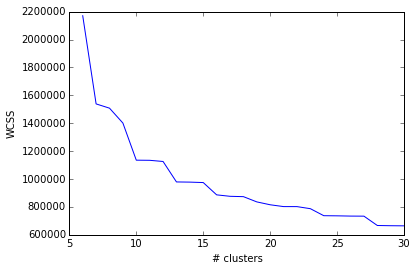

In [13]:
plt.plot(ks, wcsses)
plt.xlabel('# clusters')
plt.ylabel('WCSS');

In [14]:
# choose 13 clusters:
k = 13
g = graph.copy()

# reduces graph to i clusters
cuts[cuts['size'] <= k].apply(lambda x: a.cutrow(x, g), axis=1)

# assign cluster numbers
df['cnum'] = a.assign_clusters(df, g)

In [43]:
clist = ['#FF0000', '#FF7400', '#009999', '#00CC00',
         '#FF6363', '#FFAA63', '#46B2B2', '#54D954',
         '#FF3939', '#FF9339', '#005D5D', '#2ECF2E',
         '#C50000', '#C55900', '#007676', '#009E00',]

In [50]:
cmap = colors.Colormap('CMRmap')

In [76]:
c = matplotlib.cm.get_cmap('CMRmap')

In [104]:
np.linspace(0,256,13)

array([   0.        ,   21.33333333,   42.66666667,   64.        ,
         85.33333333,  106.66666667,  128.        ,  149.33333333,
        170.66666667,  192.        ,  213.33333333,  234.66666667,  256.        ])

In [113]:
c = matplotlib.cm.get_cmap('Set1')
clist = [colors.rgb2hex(rgb) for rgb in c(np.linspace(0,1,13))]
clist

[u'#e41a1c',
 u'#725c83',
 u'#3e8e95',
 u'#4eae4b',
 u'#7f6e85',
 u'#ba5e6e',
 u'#ff8101',
 u'#ffd522',
 u'#e1c72f',
 u'#a8572c',
 u'#dd738f',
 u'#d789b2',
 u'#999999']

In [51]:
# cmap = colors.ListedColormap(clist)
cmap = colors.Colormap('CMRmap')
bounds=range(-1, 13)
norm = colors.BoundaryNorm(bounds, cmap.N)

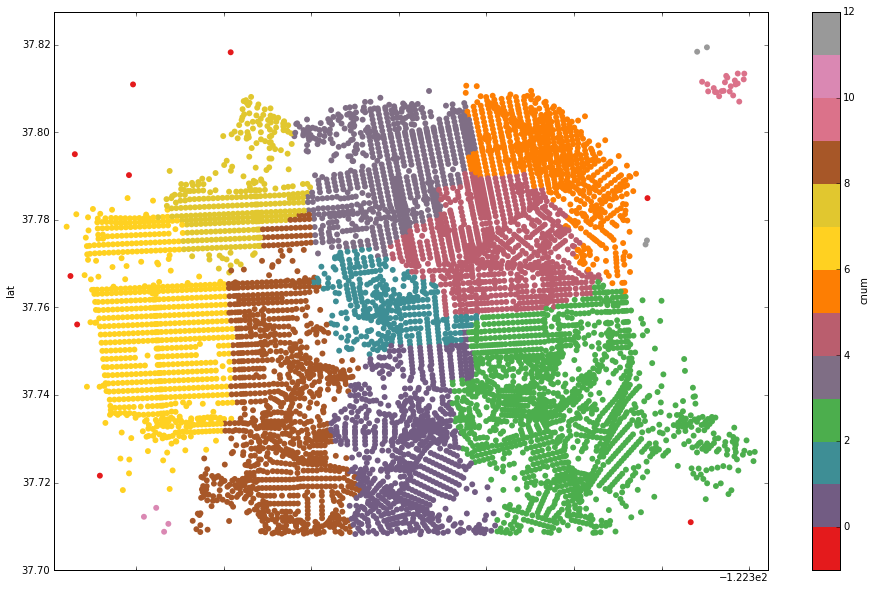

In [112]:
df.plot(kind='scatter', x = 'lon', y = 'lat', c = 'cnum',
        linewidths = 0, cmap = 'Set1', figsize = (16, 10), s=35, norm=norm)
plt.axis('equal')
plt.margins(0);

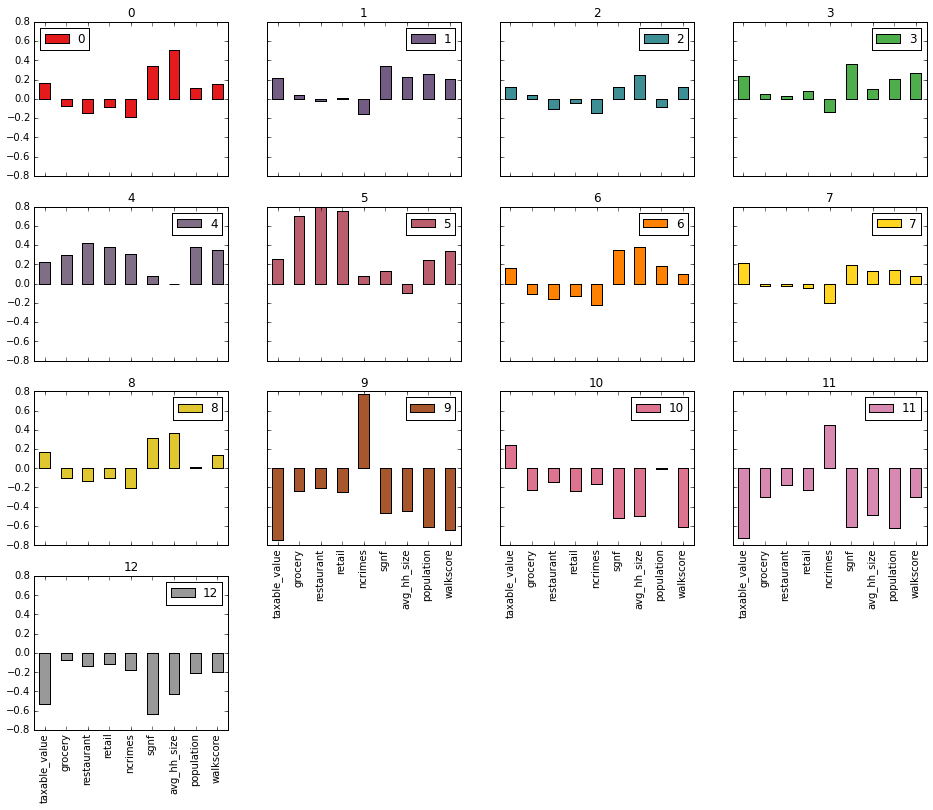

In [126]:
dfbp.T.plot(kind='bar', subplots=True, layout=(5,4), figsize = (16, 16), sharey=True,
           color = clist)
plt.title('Feature values relative to mean');

In [119]:
dfbp = df.drop(['lat', 'lon'], axis = 1).groupby('cnum').mean()
dfbp = dfbp[dfbp.index >= 0]
dfbp

,taxable_value,grocery,restaurant,retail,ncrimes,sgnf,avg_hh_size,population,walkscore
cnum,,,,,,,,,
0,-0.162638,-0.406998,-0.370850,-0.436363,-0.363251,0.287647,0.832308,-0.038500,-0.180445
1,0.295339,-0.127020,-0.148162,-0.193841,-0.239823,0.300703,0.016506,0.469849,0.101361
2,-0.479777,-0.104810,-0.295343,-0.320739,-0.198189,-0.275785,0.092870,-0.698849,-0.324871
3,0.455139,-0.092839,-0.037293,0.020147,-0.187756,0.347419,-0.351642,0.276596,0.395977
4,0.390909,0.555105,0.694395,0.822756,1.473223,-0.380589,-0.648885,0.869370,0.816712
5,0.624247,1.617881,1.395632,1.873909,0.633247,-0.255282,-0.927095,0.408352,0.738826
6,-0.171522,-0.506727,-0.411351,-0.581260,-0.508757,0.324153,0.474329,0.214132,-0.405640
7,0.274695,-0.282141,-0.142722,-0.352224,-0.429222,-0.080254,-0.266752,0.061175,-0.529804
8,-0.054822,-0.475445,-0.344076,-0.498493,-0.441167,0.219815,0.416264,-0.360382,-0.247928


In [122]:
# scale values 0-1 then subtract average
dfbp = dfbp.sub(dfbp.min(axis=0))
dfbp = dfbp.div(dfbp.max(axis=0))
dfbp = dfbp.sub(dfbp.mean(axis=0))
dfbp

,taxable_value,grocery,restaurant,retail,ncrimes,sgnf,avg_hh_size,population,walkscore
cnum,,,,,,,,,
0,0.161480,-0.070818,-0.142201,-0.081201,-0.188476,0.337580,0.505399,0.108923,0.149805
1,0.214065,0.036164,-0.024597,0.006851,-0.154848,0.342651,0.226235,0.261334,0.207319
2,0.125067,0.044651,-0.102325,-0.039222,-0.143505,0.118765,0.252367,-0.089059,0.120329
3,0.232413,0.049225,0.033954,0.084544,-0.140663,0.360794,0.100257,0.203394,0.267447
4,0.225038,0.296811,0.420366,0.375949,0.311870,0.078063,-0.001459,0.381116,0.353316
5,0.251830,0.702910,0.790697,0.757593,0.083019,0.126727,-0.096660,0.242896,0.337420
6,0.160460,-0.108926,-0.163590,-0.133809,-0.228119,0.351758,0.382900,0.184666,0.103844
7,0.211695,-0.023109,-0.021724,-0.050653,-0.206450,0.194702,0.129306,0.138808,0.078504
8,0.173860,-0.096973,-0.128061,-0.103759,-0.209704,0.311237,0.363031,0.012419,0.136032


In [117]:
dfbp

,taxable_value,grocery,restaurant,retail,ncrimes,sgnf,avg_hh_size,population,walkscore
cnum,,,,,,,,,
0,0.909650,0.226272,0.067102,0.161206,0.039643,0.976787,1.000000,0.727807,0.796489
1,0.962235,0.333255,0.184706,0.249259,0.073271,0.981857,0.720836,0.880218,0.854003
2,0.873237,0.341742,0.106978,0.203186,0.084614,0.757971,0.746968,0.529825,0.767013
3,0.980583,0.346316,0.243257,0.326952,0.087456,1.000000,0.594858,0.822278,0.914132
4,0.973208,0.593902,0.629669,0.618356,0.539989,0.717269,0.493142,1.000000,1.000000
5,1.000000,1.000000,1.000000,1.000000,0.311138,0.765934,0.397940,0.861780,0.984104
6,0.908630,0.188165,0.045713,0.108598,0.000000,0.990964,0.877501,0.803550,0.750529
7,0.959865,0.273981,0.187579,0.191755,0.021669,0.833908,0.623907,0.757691,0.725188
8,0.922030,0.200118,0.081242,0.138648,0.018415,0.950443,0.857632,0.631302,0.782717


# Gap statistic / Davies-Bouldin

https://en.wikipedia.org/wiki/Cluster_analysis#Internal_evaluation

$$DB = \frac{1}{n}\sum_{i=1}^n max \left(\frac{wcss_i + wcss_j}{featuredistance(i, j)}\right)$$

In [6]:
import networkx as nx
from sklearn.metrics.pairwise import pairwise_distances

from code.clusterize import *

In [34]:
g = nx.from_pandas_dataframe(cl, source='source', target='target')

In [ ]:
cl = pd.read_csv('results/CL010405.csv')

In [27]:
nodelist = list(set(cl.source).union(set(cl.target)))

In [41]:
df = pickle.load(open('featuresdf.pkl', 'rb'))
df = df.ix[nodelist]
fdf = df[['grocery', 'ncrimes', 'sgnf']]

In [28]:
len(nodelist)

7325

In [35]:
cl['cutcon'] = cl.apply(lambda x: cutcon(x, g), axis=1)

In [36]:
cl.head()

,source,target,num_edges,timestamp,cutcon
0,7329,1963,23555,1.447819e+09,5
1,3835,3834,23554,1.447819e+09,5
2,4804,678,23553,1.447819e+09,5
3,3835,4804,23552,1.447819e+09,5
4,1910,4804,23551,1.447819e+09,5


In [42]:
g = nx.from_pandas_dataframe(cl, source='source', target='target')
cl[cl.cutcon <= 6].apply(lambda x: cutrow(x, g), axis=1)
nx.number_connected_components(g)

6

In [43]:
cnum = assign_clusters(nodelist, g)

In [48]:
wc = wcss(fdf, cnum)
wc

cnum
0    18283.101023
1     1828.512646
2        6.890481
3        0.720246
4        0.032639
5        0.004548
Name: errors, dtype: float64

In [65]:
x, y = np.meshgrid(wc, wc)
wcgrid = pd.DataFrame(x+y)
wcgrid

,0,1,2,3,4,5
0,36566.202045,20111.613669,18289.991504,18283.821269,18283.133662,18283.105570
1,20111.613669,3657.025292,1835.403128,1829.232892,1828.545285,1828.517194
2,18289.991504,1835.403128,13.780963,7.610728,6.923120,6.895029
3,18283.821269,1829.232892,7.610728,1.440492,0.752885,0.724794
4,18283.133662,1828.545285,6.923120,0.752885,0.065278,0.037187
5,18283.105570,1828.517194,6.895029,0.724794,0.037187,0.009095


In [56]:
sum2(wc[2], wc[3])

7.6107275400335093

In [49]:
pwdist = most_similar(fdf, cnum)
pwdist

,0,1,2,3,4,5
0,0.000000,0.973769,3.574937,2.144455,2.990749,2.295404
1,0.973769,0.000000,4.147314,2.160295,3.442895,2.445441
2,3.574937,4.147314,0.000000,3.451112,1.241096,3.549913
3,2.144455,2.160295,3.451112,0.000000,2.295367,0.504576
4,2.990749,3.442895,1.241096,2.295367,0.000000,2.395042
5,2.295404,2.445441,3.549913,0.504576,2.395042,0.000000


In [85]:
dbone = wcgrid / pwdist
dbone

,0,1,2,3,4
0,inf,5783.498989,1.026990e+04,6952.963611,9388.537665
1,5.783499e+03,inf,2.205297e+00,5.578232,1.942309
2,1.026990e+04,2.205297,inf,0.328002,1.436443
3,6.952964e+03,5.578232,3.280022e-01,inf,0.015527
4,9.388538e+03,1.942309,1.436443e+00,0.015527,inf


In [88]:
np.tri(5, k=-1)

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  0.]])

In [89]:
dbone = (dbone * np.tri(5, k=-1)).fillna(0)
dbone

,0,1,2,3,4
0,0.000000,0.000000,0.000000,0.000000,0
1,5783.498989,0.000000,0.000000,0.000000,0
2,10269.900427,2.205297,0.000000,0.000000,0
3,6952.963611,5.578232,0.328002,0.000000,0
4,9388.537665,1.942309,1.436443,0.015527,0


In [96]:
dbone.max().sum()

62494.074454749512

In [98]:
%%time
ks = range(5,50)
db = []

for k in ks:
    print k,
    g = nx.from_pandas_dataframe(cl, source='source', target='target')
    cl[cl.cutcon <= k].apply(lambda x: cutrow(x, g), axis=1)
    cnum = assign_clusters(nodelist, g)
    wc = wcss(fdf, cnum)
    x, y = np.meshgrid(wc, wc)
    wcgrid = pd.DataFrame(x+y)
    pwdist = most_similar(fdf, cnum)
    dbone = wcgrid / pwdist
    dbone = (dbone * np.tri(k, k=-1)).fillna(0)
    db.append(dbone.max().sum()/k)


5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49CPU times: user 4min 25s, sys: 2.27 s, total: 4min 27s
Wall time: 4min 28s



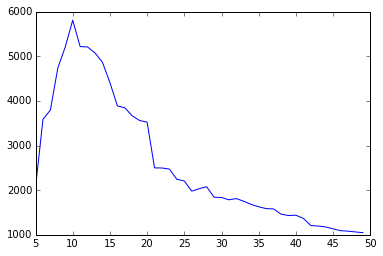

In [101]:
# strict
plt.plot(ks, db)

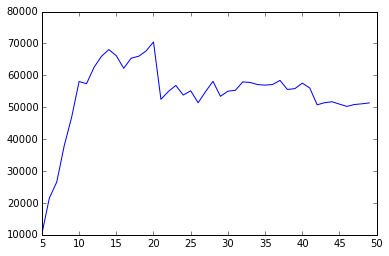

In [100]:
# not scaled by k
plt.plot(ks, np.array(db) * np.array(ks))